In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Warning disable

In [2]:
import warnings
warnings.filterwarnings('ignore')

#Load data

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/Shareddrives/PP NGHIÊN CỨU LIÊN NGÀNH/1. Cuối kỳ/Data/processed_data.csv')

In [4]:
df.head()

,Unnamed: 0,review,sentiment
0,0,nice hotel expensive parking got good deal sta...,positive
1,1,ok nothing special charge diamond member hilto...,negative
2,3,unique great stay wonderful time hotel monaco ...,positive
3,4,great stay great stay went seahawk game awesom...,positive
4,5,love monaco staff husband stayed hotel crazy w...,positive


Data splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((16476,), (1831,), (16476,), (1831,))

Tokenizer

In [6]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

Sequence

In [7]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [8]:
VOCAB_SIZE = len(t.word_index)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=18529
Number of Documents=1831


Sequence Normalization

In [9]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((16476, 100), (1831, 100))

Encoding Labels

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [11]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#Modelling

In [12]:
from tensorflow import keras
from keras.layers import Layer
from keras import backend as K


class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None


    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W)
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#Evaluation

Model Accuracy

Bi-GRU + Attention model

In [13]:
from keras.models import load_model

# Final evaluation of the model
# load the saved model
trained_model = load_model('/content/drive/Shareddrives/PP NGHIÊN CỨU LIÊN NGÀNH/1. Cuối kỳ/Test_code/Evaluation metrics/saved models/best_model_bigru.h5', custom_objects={'AttentionLayer': AttentionLayer})
train_acc = trained_model.evaluate(X_train, y_train, verbose=1)
test_acc = trained_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

58/58 [==============================] - 2s 29ms/step - loss: 0.1756 - accuracy: 0.9345
Train: 98.20%, Test: 93.45%


LSTM model only

In [14]:
trained_lstm_model = load_model('/content/drive/Shareddrives/PP NGHIÊN CỨU LIÊN NGÀNH/1. Cuối kỳ/Test_code/Evaluation metrics/saved models/best_model_lstm.h5')
train_acc = trained_lstm_model.evaluate(X_train, y_train, verbose=1)
test_acc = trained_lstm_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

58/58 [==============================] - 4s 71ms/step - loss: 0.1771 - accuracy: 0.9361
Train: 96.32%, Test: 93.61%


GRU model only

In [15]:
trained_gru_model = load_model('/content/drive/Shareddrives/PP NGHIÊN CỨU LIÊN NGÀNH/1. Cuối kỳ/Test_code/Evaluation metrics/saved models/best_model_gru.h5')
train_acc = trained_gru_model.evaluate(X_train, y_train, verbose=1)
test_acc = trained_gru_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

58/58 [==============================] - 2s 38ms/step - loss: 0.2852 - accuracy: 0.9235
Train: 99.15%, Test: 92.35%


Confusion Matrix

In [16]:
prediction_probs = trained_model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

58/58 [==============================] - 3s 40ms/step


In [17]:
prediction_probs_lstm = trained_lstm_model.predict(X_test, verbose=1).ravel()
predictions_lstm = [1 if prob > 0.5 else 0 for prob in prediction_probs_lstm]

58/58 [==============================] - 3s 42ms/step


In [18]:
prediction_probs_gru = trained_gru_model.predict(X_test, verbose=1).ravel()
predictions_gru = [1 if prob > 0.5 else 0 for prob in prediction_probs_gru]

58/58 [==============================] - 2s 24ms/step


Bi-GRU + Attention model

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       341
           1       0.94      0.98      0.96      1490

    accuracy                           0.93      1831
   macro avg       0.92      0.86      0.88      1831
weighted avg       0.93      0.93      0.93      1831



,positive,negative
positive,251,90
negative,30,1460


LSTM model only

In [20]:
print(classification_report(y_test, predictions_lstm))
pd.DataFrame(confusion_matrix(y_test, predictions_lstm), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       341
           1       0.95      0.98      0.96      1490

    accuracy                           0.94      1831
   macro avg       0.92      0.87      0.89      1831
weighted avg       0.93      0.94      0.93      1831



,positive,negative
positive,257,84
negative,33,1457


GRU model only

In [21]:
print(classification_report(y_test, predictions_gru))
pd.DataFrame(confusion_matrix(y_test, predictions_gru), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       341
           1       0.94      0.97      0.95      1490

    accuracy                           0.92      1831
   macro avg       0.89      0.85      0.87      1831
weighted avg       0.92      0.92      0.92      1831



,positive,negative
positive,247,94
negative,46,1444


ROC AUC

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Bi-GRU + Attention model

model AUC score: 0.9735420889999803


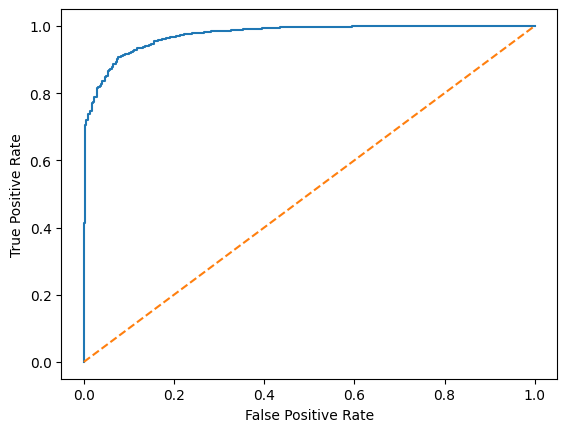

In [23]:
plot_roc_curve(y_test, prediction_probs)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs)}')

LSTM model only

model AUC score: 0.9666378003896948


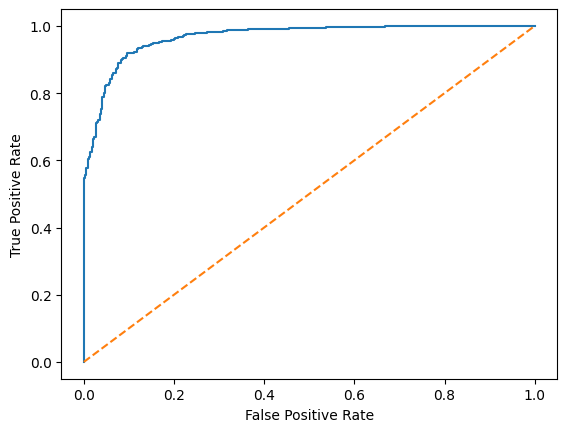

In [24]:
plot_roc_curve(y_test, prediction_probs_lstm)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs_lstm)}')

GRU model only

model AUC score: 0.9581166722431065


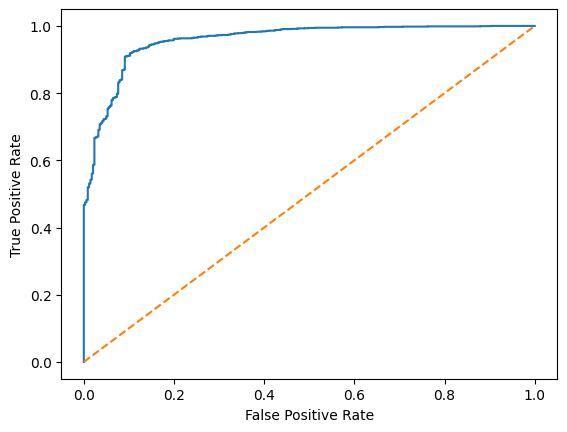

In [25]:
plot_roc_curve(y_test, prediction_probs_gru)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs_gru)}')

Precision-Recall

Bi-GRU + Attention model

model f1 score: 0.9605263157894737 model AUC score: 0.9936002334284194


Text(0, 0.5, 'Precision')

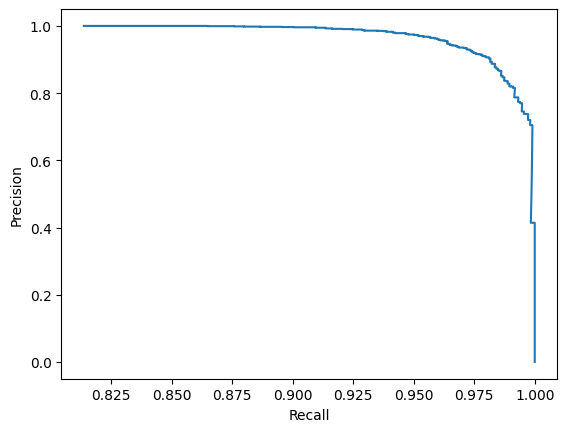

In [26]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs)
print(f'model f1 score: {f1_score(y_test, predictions)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')

LSTM model only

model f1 score: 0.9613988782580007 model AUC score: 0.9917291114177194


Text(0, 0.5, 'Precision')

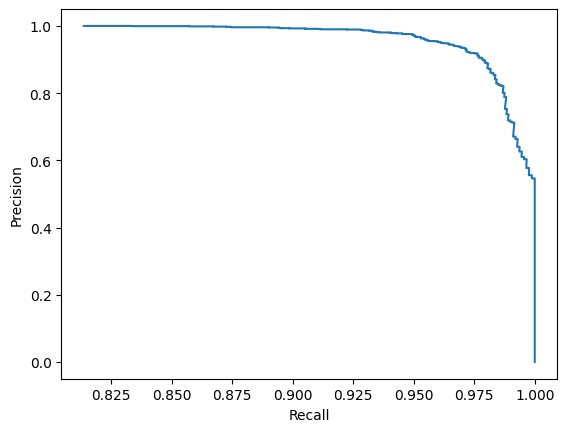

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs_lstm)
print(f'model f1 score: {f1_score(y_test, predictions_lstm)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')

GRU model only

model f1 score: 0.9537648612945838 model AUC score: 0.9893075595745925


Text(0, 0.5, 'Precision')

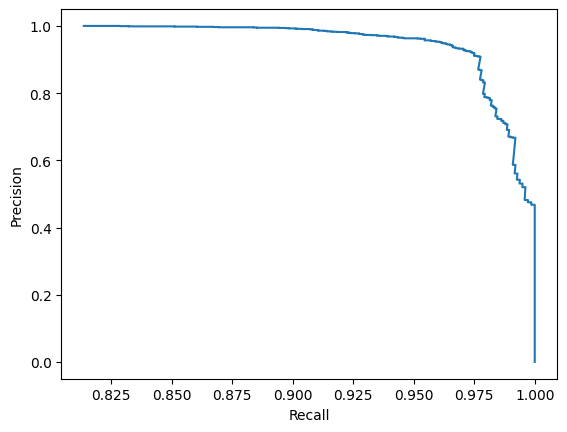

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs_gru)
print(f'model f1 score: {f1_score(y_test, predictions_gru)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')